# 셸로우 포커스 만들기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

print('슝=3')

슝=3


## 본인 사진

### 준비한 이미지 읽기

(1440, 1159, 3)


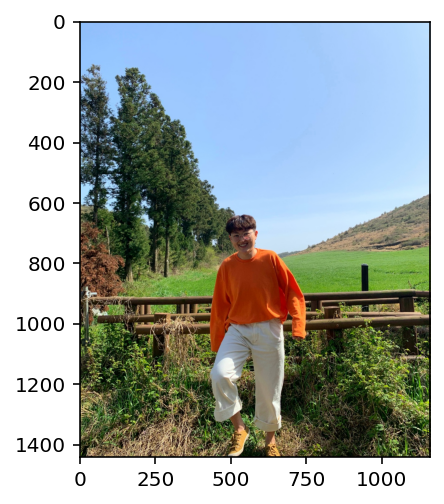

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/san.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법 - 이미지 세그멘테이션(image segmentation)

우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션 - 시맨틱 세그멘테이션(semantic segmentation)

사람 개개인별로 다른 라벨을 가지게 하는 세그멘테이션 - 인스턴스 세그멘테이션(Instance segmentation)

## 시맨틱 세그멘테이션 다뤄보기

### PixelLib에서 제공해 주는 모델 다운로드

In [3]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f400c2aa0d0>)

### PixelLib로 사용할 세그멘테이션 모델 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수

PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

In [6]:
#PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

사람(person) 라벨, 즉 15를 가진 영역만 검출

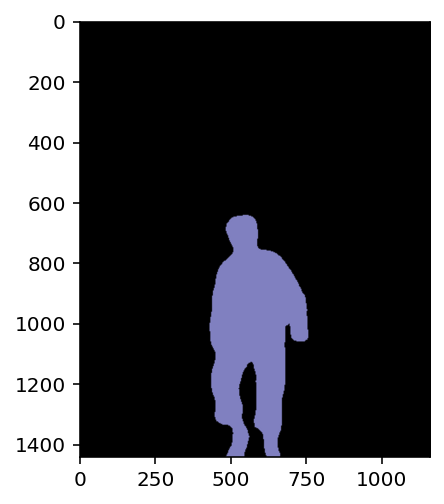

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]
#15번쨰가 나타내는 색깔

array([192, 128, 128])

In [12]:
seg_color = (128,128,192)
#추출해야 하는 색상 값은 순서를 바꿔줘야함

(1440, 1159)


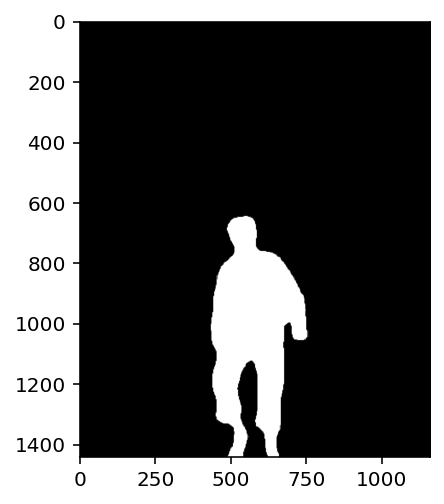

In [13]:
#seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

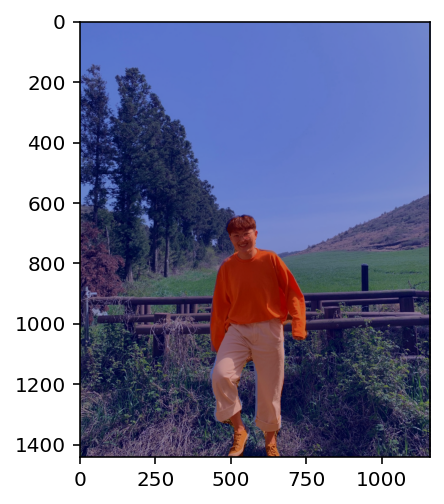

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 하기

blur() 함수 이용

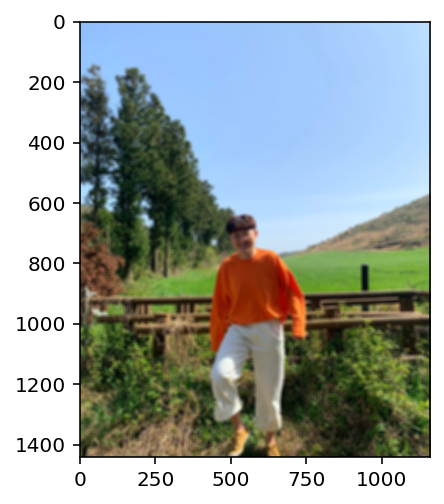

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에서 세그멘테이션 마스크를 이용하여 배경만 추출

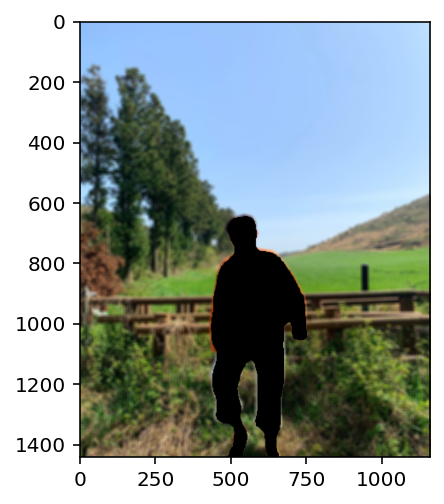

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전

원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0

## 흐린 배경과 원본 영상 합성

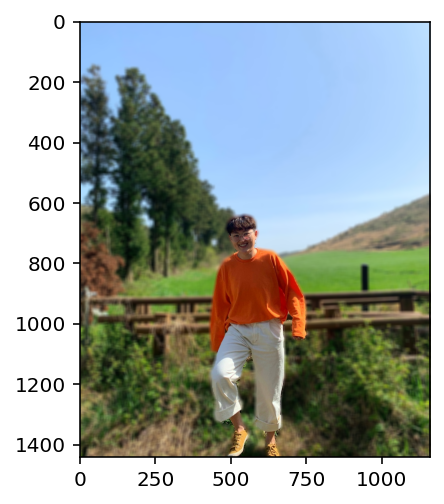

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용

# 고양이

### 준비한 이미지 읽기

(1280, 960, 3)


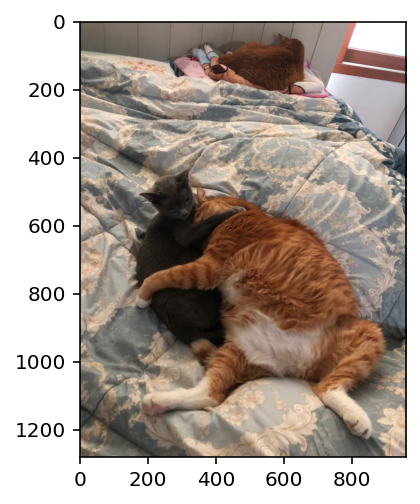

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/three.png'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f3fa277ddc0>)

In [20]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [21]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [22]:
#PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

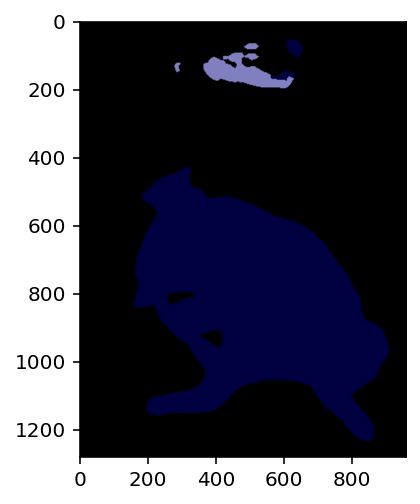

In [23]:
plt.imshow(output)
plt.show()

In [24]:
segvalues

{'class_ids': array([ 0,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [25]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person


In [26]:
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [27]:
colormap[8]
#8번쨰 나타내는 색깔

array([64,  0,  0])

In [28]:
seg_color = (0, 0 ,64)
#추출해야 하는 색상 값은 순서를 바꿔줘야함

(1280, 960)


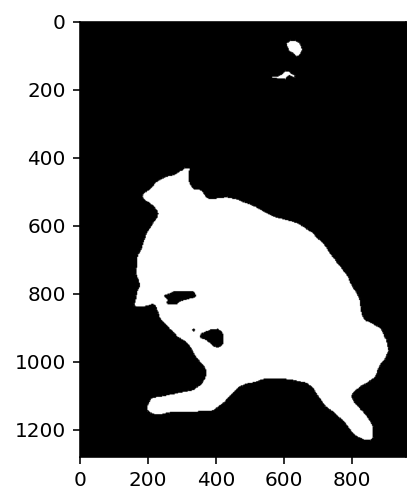

In [29]:
#seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

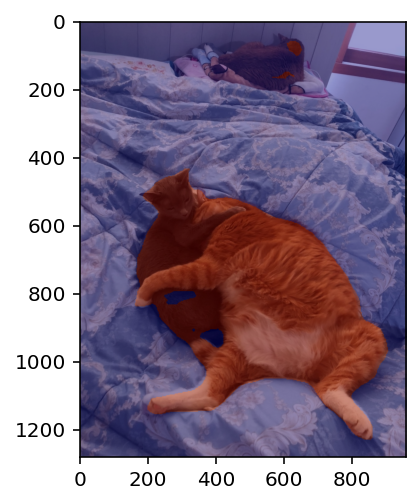

In [30]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 뒤에 고양이가 인식되지 않음

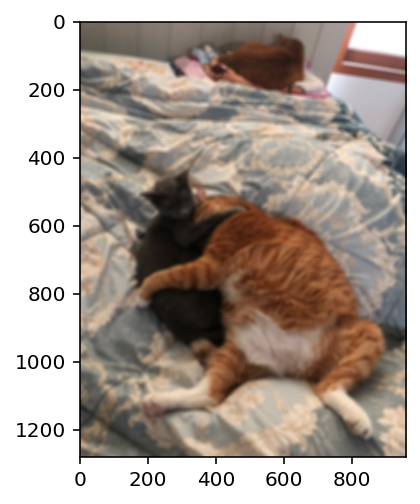

In [31]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

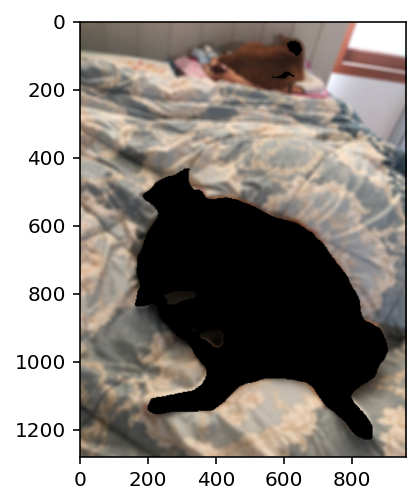

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

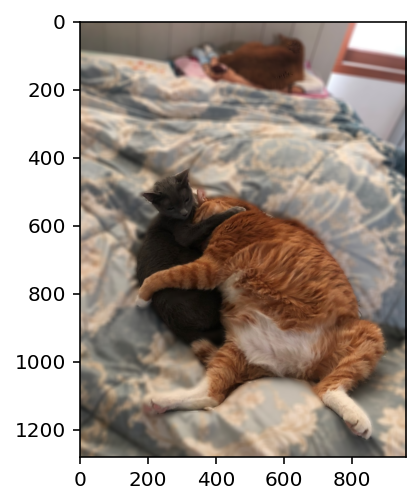

In [33]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 뒤에 고양이를 인식하지 못함

## 배경전환 크로마키

(1280, 961, 3)


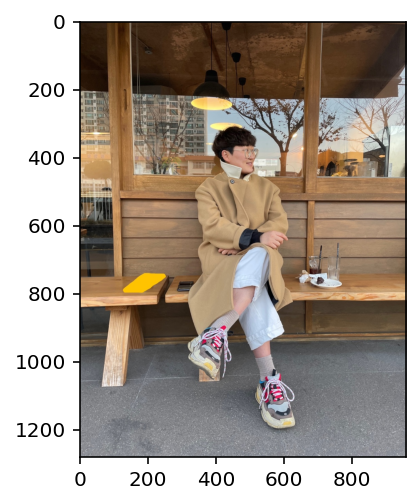

In [34]:
# 고양이 이미지
cafe_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cafe.png'  # 본인이 사용할 사진의 경로
cafe_img_orig = cv2.imread(cafe_img_path)
print(cafe_img_orig.shape)

cafe_img_rgb = cv2.cvtColor(cafe_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cafe_img_rgb)
plt.show()

In [35]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [36]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(cafe_img_path)

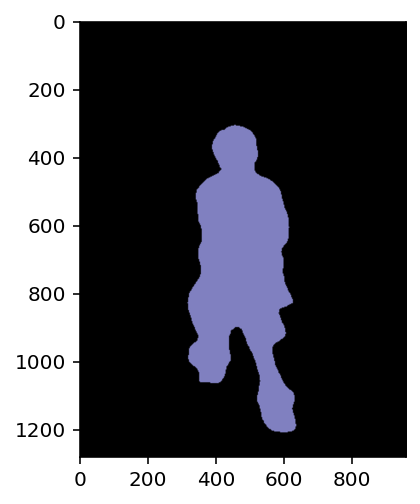

In [37]:
plt.imshow(output)
plt.show()

In [38]:
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [39]:
colormap[15]
#15번쨰가 나타내는 색깔

array([192, 128, 128])

In [40]:
seg_color = (128,128,192)
#추출해야 하는 색상 값은 순서를 바꿔줘야함

(1280, 961)


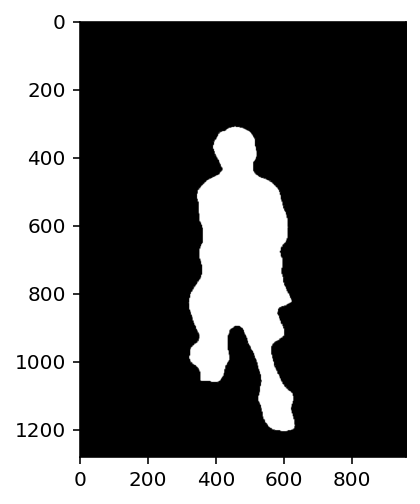

In [41]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

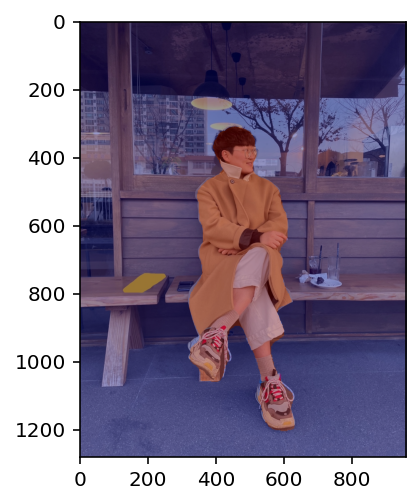

In [42]:
cafe_img_show = cafe_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cafe_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(cafe_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cafe_img_show = cv2.addWeighted(cafe_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cafe_img_show, cv2.COLOR_BGR2RGB))
plt.show()

(381, 385, 3)


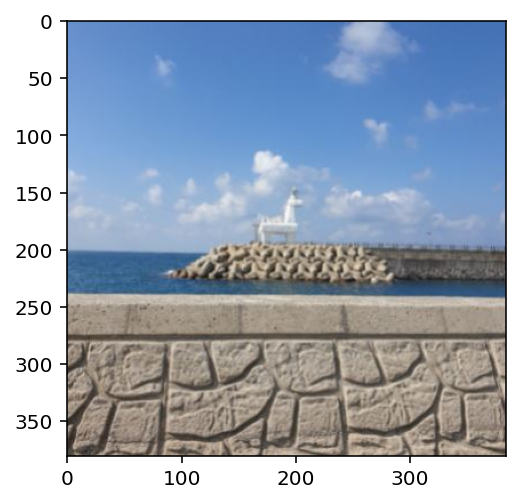

In [43]:
# 배경 이미지
sea_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.png'  # 본인이 사용할 사진의 경로
sea_img_orig = cv2.imread(sea_img_path)
print(sea_img_orig.shape)

sea_img_rgb = cv2.cvtColor(sea_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(sea_img_rgb)
plt.show()

In [44]:
target_size = (cafe_img_orig.shape[1], cafe_img_orig.shape[0])
sea_img_orig_resized = cv2.resize(sea_img_orig, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

In [45]:
print(sea_img_orig_resized.shape)

(1280, 961, 3)


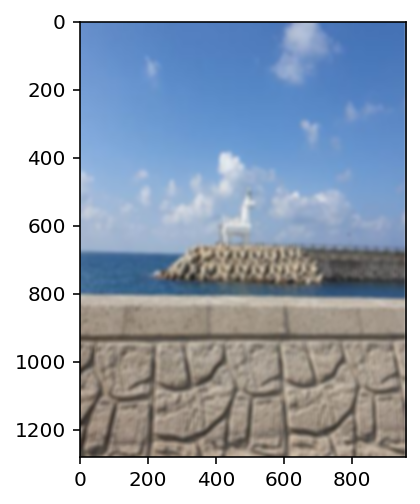

In [46]:
sea_img_orig_blur = cv2.blur(sea_img_orig_resized, (13,13))  
plt.imshow(cv2.cvtColor(sea_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

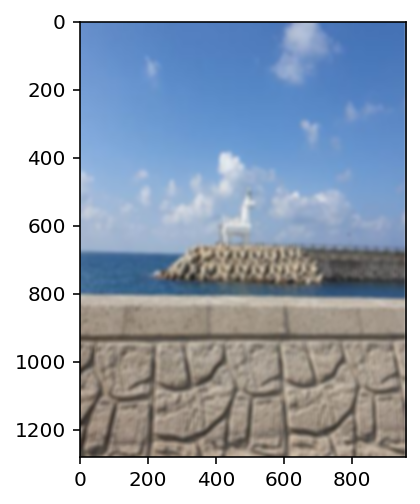

In [47]:
img_mask_color = cv2.cvtColor(cafe_img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(sea_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(sea_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

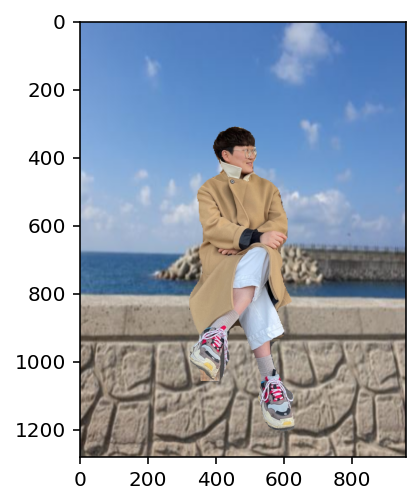

In [48]:
img_concat = np.where(img_mask_color==255, cafe_img_orig, sea_img_orig_resized)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 회고

### 이번 프로젝트에서 어려웠던 점

 처음 사진을 불러올 때부터 원본사진을 올렸음에도 불구하고 처음부터 뚜렷한 사진이 올려지지가 않아서 배경을 흐릿하게 하고 인물사진 모드를 해도 별다른 차이점을 볼 수가 없어서 힘들었다.

 배경과 사진 사이즈를 맞추기 위해 resize를 하는데 계속 반대로 resize가 되어서 힘들었는데, 또 사이즈를 맞추고 나니까 색깔이 변하는 문제가 생겨서 힘들었다
 
 욕심이 생겨 앉아있는 사진을 선택했지만 자연스럽게 앉아있는 것처럼 보이도록 하는 것이 힘들었다 


### 프로젝트를 진행하면서 알아내거나 모호한 점

 배경사진 resize를 다 해놓고 합성할 때 resize하기 전 사진과 합성을 시도하면 error가 뜬다. 사진과 배경이 사이즈가 같아야 하는 것을 알았다.

 세그멘테이션 모델에는 많은 모델들이 있는데 이번 프로젝트에서는 DeepLab v3+를 사용하였는데 deeplab은 semantic segmentation 정확성을 높이기 위한방법으로 atrous convolution을 사용한다 그래서 모델중에 mono+stero_640x192모델을 사용하면, depth가 반영된 이미지로 좀더 깔끔하게 잘나올 수 있다.

# 뒤쪽에 있는 고양이를 인식하지 못함

## 인스턴스 세그멘테이션을 활용

 인스턴스 세그멘테이션 '고양이'라는 하나의 추상적인 정보를 이미지에서 추출해내는 시맨틱 세그멘테이션과 달리 고양이 개별적으로 다른 라벨을 가지게 합니다.  인스턴스의 id 뿐만이 아닌 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능합니그러므로 위의 이미지와 같이 여러 고양이가 한 이미지에 등장할 때 인스턴스 세그멘테이션을 이용한다면 각 객체를 분할해서 인식할 수 있을 것 같습니다. 

### 루브릭 평가 지표에 맞추기 위해 시도한 것

 화질이 좋지 않은 사진을 위해( %config InlineBackend.figure_format = 'retina )

 어떻게 하면 경계가 잘 맞춰지게 될까 생각하고 검색해보았다.

 배경과 모델의 경계가 모호하여서(배경이 흰색, 고양이 털이 흰색) 사진을 바꾸는 시도를 하였다.

### 자기다짐

cv쪽이 많이 약한 것 같다. 곧 중요한 결정을 해야하는 만큼 cv도 열심히 공부해보자.